In [73]:
import os
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as cb
from sklearn import tree, svm
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time
import division_into_classes as dic

In [2]:
cognitive_indicator = 'corsi'
indicator_folder = "D:/unn/down_syndrome_epigenetic/{0}".format(cognitive_indicator)
alpha = 0.001

correlation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\{0}\correlation_frame.txt".format(cognitive_indicator), sep = '\t', index_col = 0)
methylation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\{0}\methylation_frame.txt".format(cognitive_indicator), sep = '\t', index_col = 0)
cognitive_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\{0}\cognitive_frame.txt".format(cognitive_indicator), sep = '\t', index_col = 0)

In [3]:
classes_all_members, classes_unique_members = dic.division_into_classes (cognitive_indicator, cognitive_frame)
print('Division into classes \nall values:', *classes_all_members, '\nunique values:', *classes_unique_members)
division_method = int(input('\nChoose how to divide into classes:\n1. all values\n2. unique values\n3. manual division\n'))
if division_method == 3:
    print(sorted(list(cognitive_frame[cognitive_indicator])))
    lim1, lim2 = [int(i) for i in input('Enter boundary values: ').split(' ')]
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method, lim1, lim2)
else:
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method)

Division into classes 
all values: 14 8 6 
unique values: 9 13 6

Choose how to divide into classes:
1. all values
2. unique values
3. manual division
2


1) Мультиколлинеарность:

In [11]:
def hyperparameter_optimization (model, params, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)
    pipeline = Pipeline([('standard_scaler', StandardScaler()), ('model', model)])

    grid_cv = GridSearchCV(pipeline, params, cv = 5, n_jobs = -1, scoring = 'accuracy')
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)
    best_params = grid_cv.best_params_
    cv_err = grid_cv.best_score_

    return cv_err, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average = 'macro')

In [12]:
X = methylation_frame[correlation_frame.index]
y = indicator_classes['class']

t1 = time.time()
dtree_model = tree.DecisionTreeClassifier(random_state = 111)
params = {'model__max_depth': range (1, 5)}
cv_err, acc, f1 = hyperparameter_optimization(dtree_model, params, X, y)
print('Decision Tree:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

rf_model = RandomForestClassifier(random_state = 111)
params = {'model__n_estimators': range (10, 110, 10),
          'model__max_depth': range (1, 5)}
cv_err, acc, f1 = hyperparameter_optimization(rf_model, params, X, y)
print('Random Forest:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

xg_model = xgb.XGBClassifier(objective ='multi:softprob', verbose_eval = False, random_state = 111)
params = {'model__max_depth': [2, 3, 4], 
          'model__n_estimators': range(10, 110, 10), 
          'model__learning_rate': [0.01, 0.05, 0.1],
          'model__colsample_bytree': [0.3, 0.5, 1.0],
          'model__gamma': [0.1, 0.5, 1, 1.5],
          'model__learning_rate': [0.001, 0.01],
          'model__min_child_weight': [1, 5, 10],
          'model__subsample': [0.6, 0.8, 1.0]}
cv_err, acc, f1 = hyperparameter_optimization(xg_model, params, X, y)
print('XGBoost:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

cb_model = cb.CatBoostClassifier(loss_function = 'MultiClass', logging_level = 'Silent', random_state = 111)
params = {'model__iterations': [100, 150, 200], 
          'model__learning_rate': [0.03, 0.05, 0.1], 
          'model__depth': [2, 3, 4], 
          'model__l2_leaf_reg': [0.2, 0.5, 1, 3]}
cv_err, acc, f1 = hyperparameter_optimization(cb_model, params, X, y)
print('Catboost:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)
    
lda_model = LDA()
params = {'model__n_components': range(1, 4)}
cv_err, acc, f1 = hyperparameter_optimization(lda_model, params, X, y)
print('LDA:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

qda_model = QDA()
params = {'model__reg_param': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
          'model__tol': [0.0001, 0.001, 0.01, 0.1]}
cv_err, acc, f1 = hyperparameter_optimization(qda_model, params, X, y)
print('QDA:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

log_model = LogisticRegression(solver = 'liblinear', random_state = 111)
params = {'model__C': np.logspace(-3, 3, 7), 
          'model__penalty': ['l1', 'l2']}
cv_err, acc, f1 = hyperparameter_optimization(log_model, params, X, y)
print('Logistic regression:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

svc_linear = svm.SVC(kernel = 'linear', random_state = 111)
params = {'model__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}
cv_err, acc, f1 = hyperparameter_optimization(svc_linear, params, X, y)
print('SVC linear:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

svc_rbf = svm.SVC(kernel = 'rbf', random_state = 111)
params = {'model__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 
          'model__coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
          'model__C': [40, 50, 60, 70, 80, 90]}
cv_err, acc, f1 = hyperparameter_optimization(svc_rbf, params, X, y)
print('SVC rbf:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)

svc_poly = svm.SVC(kernel = 'poly', random_state = 111)
params = {'model__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0], 
          'model__coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0], 
          'model__C': [0.001, 0.01, 0.1, 1.0, 2.0, 5.0]}
cv_err, acc, f1 = hyperparameter_optimization(svc_poly, params, X, y)
print('SVC poly:', '\ncv_err =', cv_err, 'acc =', acc, 'F1 =', f1)
t2 = time.time()
print('Time:', t2 - t1)

Decision Tree: 
cv_err = 0.42000000000000004 acc = 0.6666666666666666 F1 = 0.48888888888888893
Random Forest: 
cv_err = 0.53 acc = 0.5 F1 = 0.5222222222222223
[08:49:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose_eval" } are not used.

XGBoost: 
cv_err = 0.64 acc = 0.6666666666666666 F1 = 0.48888888888888893
Catboost: 
cv_err = 0.6 acc = 0.6666666666666666 F1 = 0.6666666666666666
LDA: 
cv_err = 0.5 acc = 0.6666666666666666 F1 = 0.6666666666666666



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 576, in fit
    raise ValueError(
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

One or more of the test scores are non-finite: [0.5 0.5 nan]
Variables are collinear


QDA: 
cv_err = 0.45999999999999996 acc = 0.3333333333333333 F1 = 0.3
Logistic regression: 
cv_err = 0.5900000000000001 acc = 0.6666666666666666 F1 = 0.48888888888888893
SVC linear: 
cv_err = 0.6 acc = 0.6666666666666666 F1 = 0.6555555555555556
SVC rbf: 
cv_err = 0.51 acc = 0.6666666666666666 F1 = 0.6555555555555556
SVC poly: 
cv_err = 0.5900000000000001 acc = 0.6666666666666666 F1 = 0.6666666666666666
Time: 1009.0467839241028


2) Устойчивость:

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Variables are collinear


  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

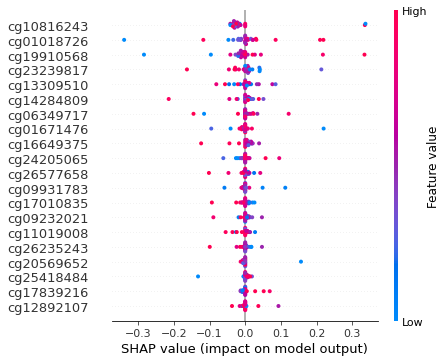

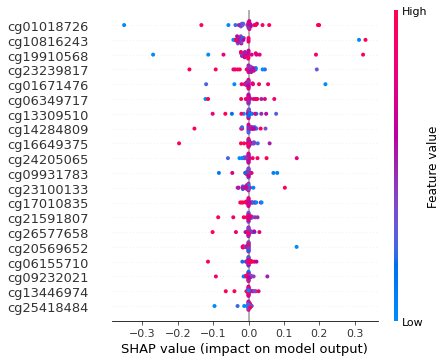

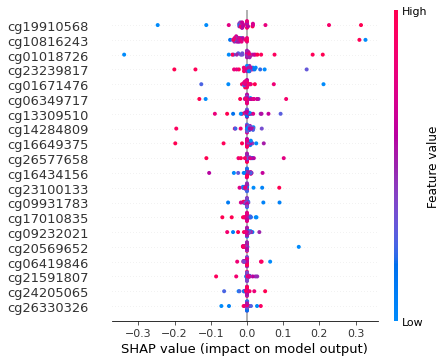

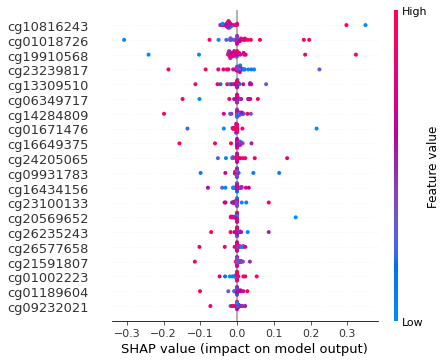

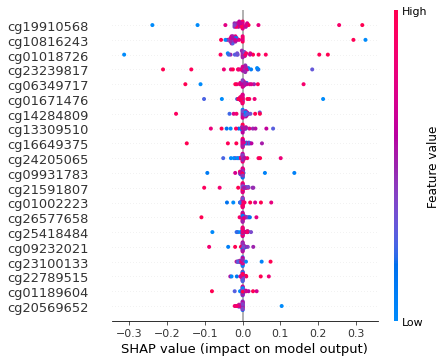

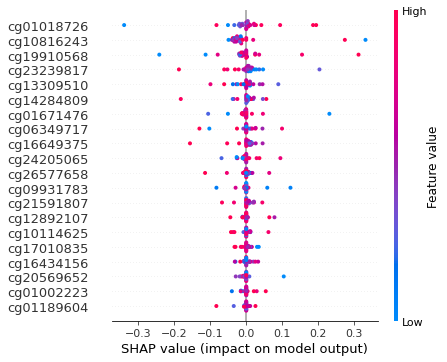

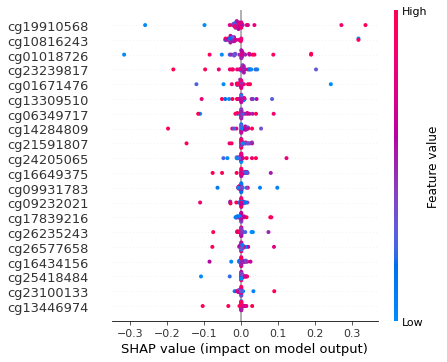

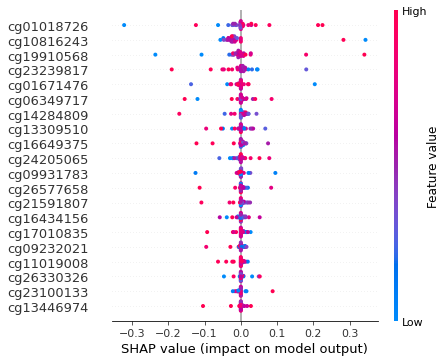

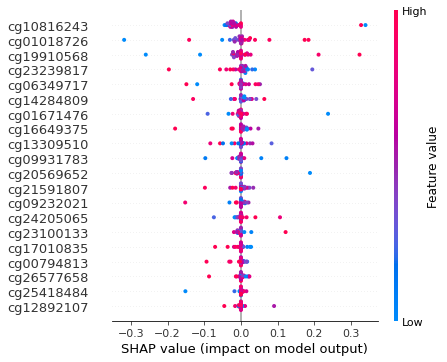

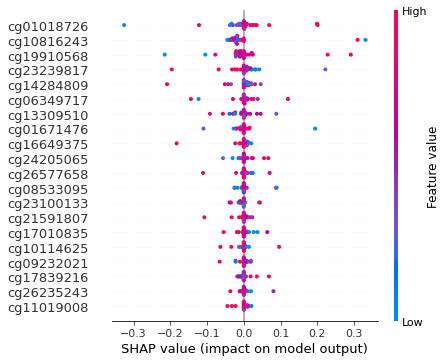

In [74]:
#indicator_classes = indicator_classes.drop('value', axis=1)
X = methylation_frame[correlation_frame.index]
y = indicator_classes

model = QDA()
params = {'model__reg_param': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
          'model__tol': [0.0001, 0.001, 0.01, 0.1]}

pipeline = Pipeline([('standard_scaler', StandardScaler(with_mean=False)), ('model', model)])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

result = []
k = 0
while k != 10:

    grid_cv = GridSearchCV(estimator = pipeline, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
    grid_cv.fit(X_train.values, np.ravel(y_train, order = 'C'))
    #grid_cv.fit(X_train, y_train)

    explainer = shap.KernelExplainer(grid_cv.predict, X)
    shap_values = explainer.shap_values(X)    
    indicator_folder_SHAP = '{0}/SHAP_{1}'.format(indicator_folder, k)
    if not os.path.isdir(indicator_folder_SHAP):
            os.mkdir(indicator_folder_SHAP)
    
    x, y = 15, 12
    fig_inch = (x/2.54, y/2.54)
    fig = plt.figure()
    shap.summary_plot(shap_values, features = X, feature_names = correlation_frame.index, show = False)
    plt.gcf().set_size_inches(fig_inch)
    fig.patch.set_facecolor('white')
    fig.savefig('{0}/beeswarm_{1}.png'.format(indicator_folder_SHAP, k), format = 'png', dpi = 300, bbox_inches = 'tight')
    
    vals = np.abs(shap_values).mean(0)[0:30]
    feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)),columns = ['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by = ['feature_importance_vals'], ascending = False, inplace = True)
    result.append(list(feature_importance['col_name']))

    for patient_number in range(len(shap_values)):
        fig = plt.figure()
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[patient_number], 
                                               feature_names = correlation_frame.index, show = False)
        plt.gcf().set_size_inches(fig_inch)
        fig.patch.set_facecolor('white')
        fig.savefig('{0}/waterfall_legacy_{1}.png'.format(indicator_folder_SHAP, patient_number), 
                        format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.close()
    k += 1
    

In [69]:
general_cpgs = list(set(result[0]) & set(result[1]) & set(result[2]) & set(result[3]) &
                    set(result[4]) & set(result[5]) & set(result[6]) & set(result[7]) & 
                    set(result[8]) & set(result[9]))
print(len(general_cpgs))

30


3) Регуляризация:

In [70]:
lasso_model = Lasso()

alphas_array = [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]

grid_cv = GridSearchCV(lasso_model, param_grid = {'alpha': alphas_array}, 
                       cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('cv min error =', grid_cv.best_score_ * (-1))
print('alpha =', grid_cv.best_estimator_.alpha)

lasso_best_model = Lasso(alpha = grid_cv.best_estimator_.alpha)
lasso_best_model.fit(X_train, y_train)
print('MSE train =', mean_squared_error(y_train, lasso_best_model.predict(X_train)))
print('MSE test =', mean_squared_error(y_test, lasso_best_model.predict(X_test)))

cv min error = 0.2387674398487188
alpha = 0.0001
MSE train = 2.7489395571561635e-05
MSE test = 0.3005378698474193


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e-02, tolerance: 1.182e-03
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e-02, tolerance: 1.182e-03


In [ ]:
enet_cv_model = ElasticNetCV(cv = 5).fit(X_train, y_train)
enet_cv_model.alpha_

In [ ]:
reg = LassoLarsCV(cv = 5).fit(X, y)
reg.score(X, y)
reg.alpha_